In [1]:
import pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [3]:
debug=False
submission=False
batch_size=32
device='cuda'
out=r'C:\Users\Kaggle\BengaliAI\V11_output'
image_size=112*2 #64*2
arch='pretrained'
model_name='densenet121'

In [4]:
datadir = Path(r'C:\Users\Kaggle\BengaliAI\inputs\bengaliai-cv19')
featherdir = Path(r'C:\Users\Kaggle\BengaliAI\inputs\bengaliaicv19feather')
outdir = Path(r'C:\Users\Kaggle\BengaliAI\V13_output\epoch_0_to_150')

In [5]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [6]:
%%time

train = pd.read_csv(datadir/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)


image_df_list 4
Wall time: 14.2 s


<a id="dataset"></a>
# Dataset

In [7]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


In [8]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        x = x.astype(np.double)
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


In [9]:
train_dataset = BengaliAIDataset(train_images, train_labels)

image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


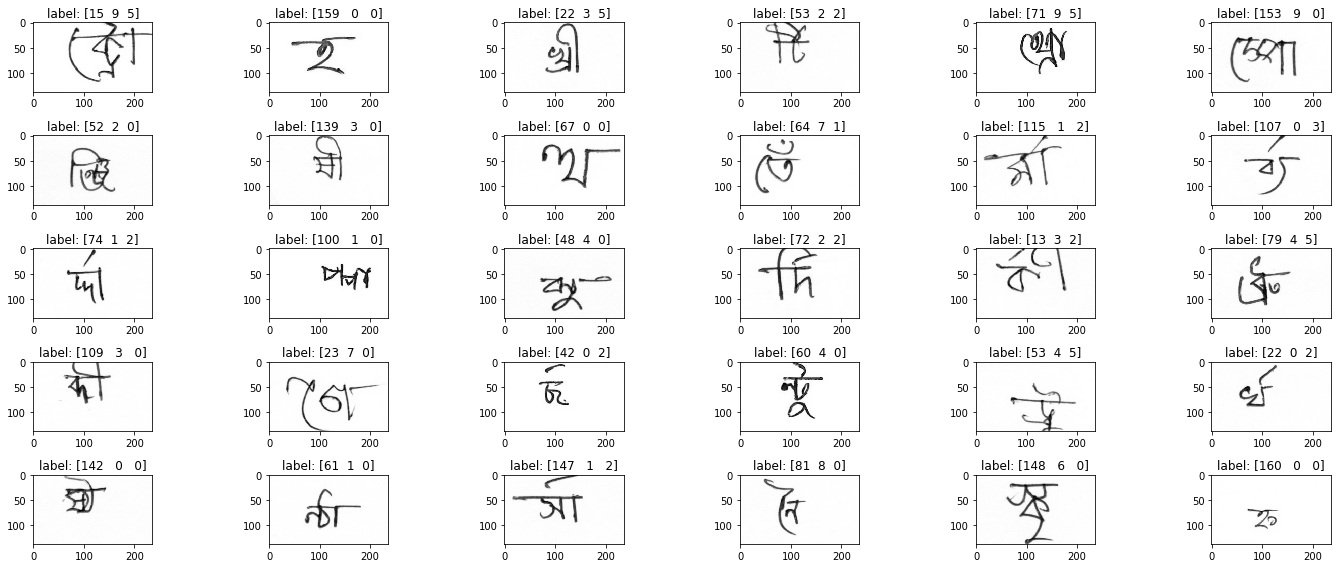

<Figure size 432x288 with 0 Axes>

In [10]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [11]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    
    #print("img.shape:", img.shape)
    
    # horizontal flip
    #if np.random.rand()<0.5:
    #img = img[:,::-1]
    
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 4
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    #tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
    #                        translation=(tx, ty))
    tform = AffineTransform(scale=(sx, sy), shear=shear_angle, rotation=rot_angle)
    
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


from scipy.ndimage.measurements import label

def connected_comp(array):
    
    structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
    labeled, ncomponents = label(array, structure)
    
    valid = []
    for i in range(1,ncomponents+1):
        if np.sum(labeled == i)>10:
            valid.append(i)

    new_array = np.zeros(array.shape)
    for i in valid:
        new_array += labeled==i
    return new_array

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    
    image[image < 20./255.] = 0
    
    is_black = image > threshold
    is_black[:5,:] = 0
    is_black[-5:,:] = 0
    is_black[:,:5] = 0
    is_black[:,-5:] = 0
    #is_black = connected_comp(is_black)
    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left-5:height - right+5, top-5:width - bottom+5]
    
    lx, ly = height - right - left + 10, width - bottom - top + 10
    l = max(lx,ly)
    #make sure that the aspect ratio is kept in rescaling
    cropped_image = np.pad(cropped_image, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    
    # scaling
    cropped_image = cropped_image*(1/cropped_image.max())
    
    #pad
    cropped_image = np.pad(cropped_image, 8, pad_with)
    
    return cropped_image

def resize(image, size=(image_size, image_size)):
    return cv2.resize(image, size)

In [12]:
# Erosion
def erosion(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 3, 2)))
    img = cv2.erode(img, kernel, iterations=1)
    return img

# Dilation
def dilation(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 3, 2)))
    img = cv2.dilate(img, kernel, iterations=1)
    return img


def get_random_kernel():
    structure = np.random.choice([cv2.MORPH_RECT, cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS])
    kernel = cv2.getStructuringElement(structure, tuple(np.random.randint(1, 3, 2)))
    return kernel

# Opening
def opening(img):
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    return img

#Closing
def closing(img):
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    return img


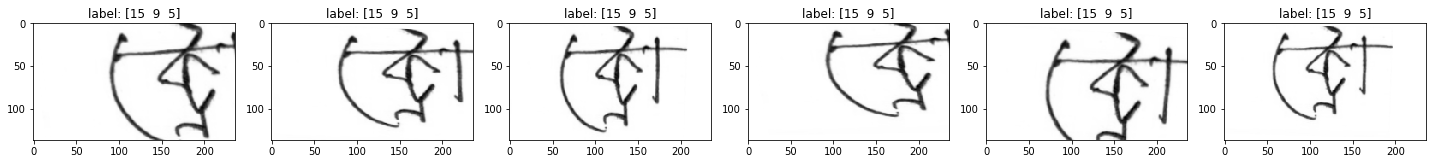

In [13]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[0]
    ax.imshow(affine_image(image), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

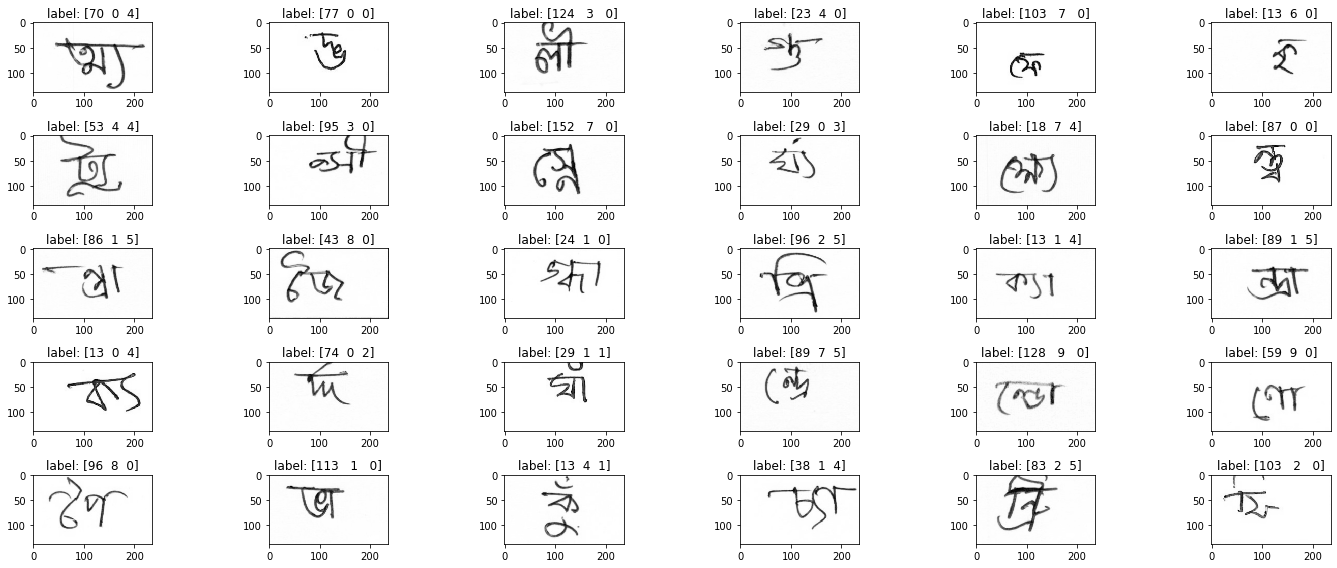

In [14]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i+30*5]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

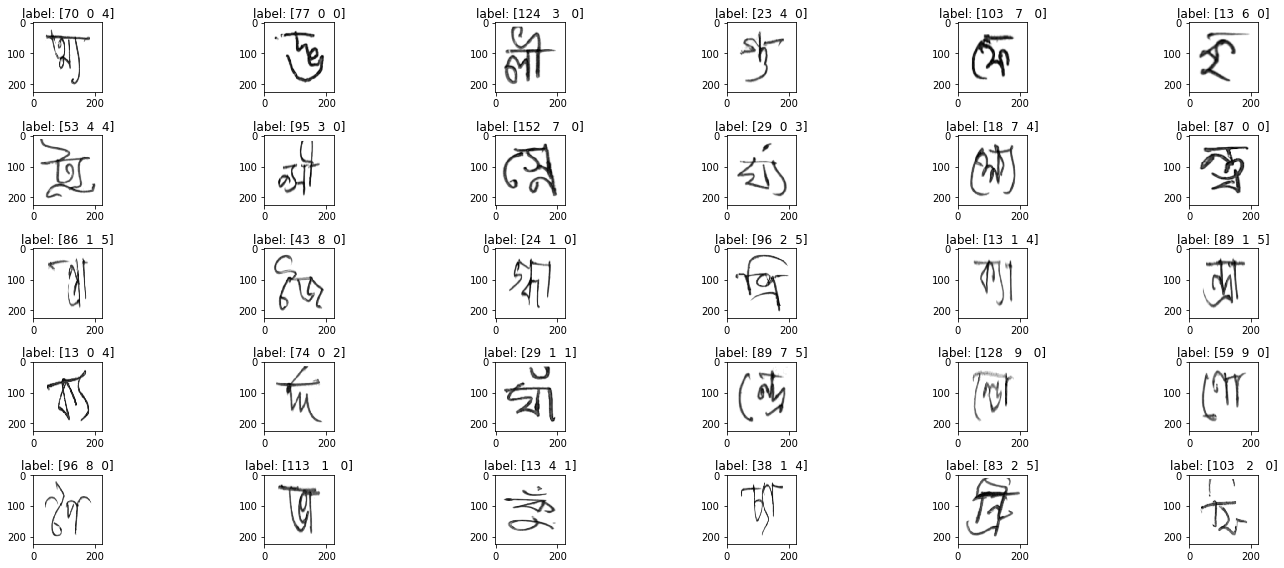

In [15]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i+30*5]
    ax.imshow(resize(crop_char_image(image, threshold=40./255.)), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [16]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']
        
        
class Transform:
    def __init__(self, affine=True, crop=False, size=(image_size, image_size),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
                    
        # remove noise
        # x [x<28./255.] = 0
        
        # horizontal flip
        #x = x[:,:,::-1,:]

        
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
        
        

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
            x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.01,#0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)

            
        #plt.imshow(x[0,0].cpu().numpy())
        #plt.show()
        
        #if self.normalize:
        #    x = (x.astype(np.float32) - 0.0692) / 0.2051
        # normalize by its max val
        # x = x * (255./x.max())
        
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x
        

In [17]:
train_transform = Transform( crop=False,
    size=(image_size, image_size), threshold=40.,
    sigma=-1., blur_ratio=0, noise_ratio=0, cutout_ratio=0,
    grid_distortion_ratio=0, random_brightness_ratio=0,
    piece_affine_ratio=0.2, ssr_ratio=0.2)

In [18]:
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

In [19]:
class Cutout:
    def __init__(self, mask_size, p, cutout_inside, mask_color=1):
        self.p = p
        self.mask_size = mask_size
        self.cutout_inside = cutout_inside
        self.mask_color = mask_color

        self.mask_size_half = mask_size // 2
        self.offset = 1 if mask_size % 2 == 0 else 0

    def __call__(self, image):
        image_all = copy.copy(image)
        image = image[0,0]
        #image = np.asarray(image).copy()

        if np.random.random() > self.p:
            return image

        h, w = image.shape[:2]

        if self.cutout_inside:
            cxmin, cxmax = self.mask_size_half, w + self.offset - self.mask_size_half
            cymin, cymax = self.mask_size_half, h + self.offset - self.mask_size_half
        else:
            cxmin, cxmax = 0, w + self.offset
            cymin, cymax = 0, h + self.offset

        cx = np.random.randint(cxmin, cxmax)
        cy = np.random.randint(cymin, cymax)
        xmin = cx - self.mask_size_half
        ymin = cy - self.mask_size_half
        xmax = xmin + self.mask_size
        ymax = ymin + self.mask_size
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(w, xmax)
        ymax = min(h, ymax)
        
        
        image_all[:, :, ymin:ymax, xmin:xmax] = self.mask_color
        return image_all

In [20]:
cutout = Cutout(32*2, 1, True, 0)

### Let's final check the processed images, which will be trained by the model.

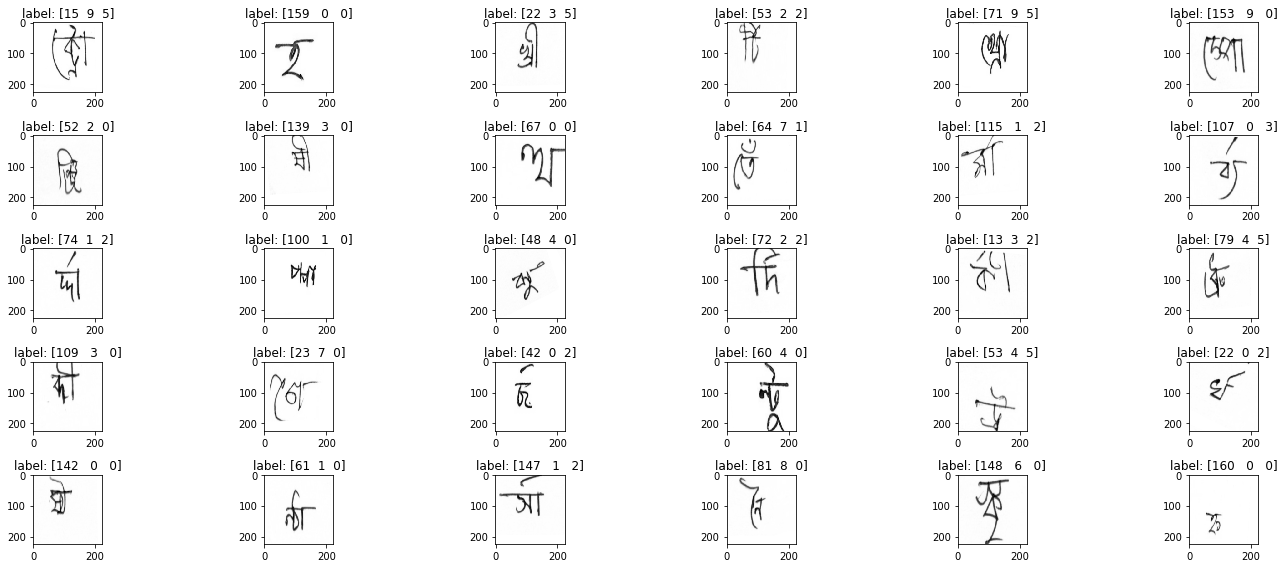

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [22]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [23]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [24]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [25]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [26]:
# GEM
# import torch.nn.functional as F

def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [27]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='densenet121',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1_1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin1_2 = LinearBlock(hdim, 168, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers1 = Sequential(lin1_1, lin1_2)
        
        lin2_1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2_2 = LinearBlock(hdim, 11, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers2 = Sequential(lin2_1, lin2_2)

        lin3_1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin3_2 = LinearBlock(hdim, 7, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers3 = Sequential(lin3_1, lin3_2)

        self.pool = GeM()

    def forward(self, x):
        
        h = self.conv0(x)
        h = self.base_model.features(h)
        
        if self.do_pooling:
            
            #h1 = torch.sum(h, dim=(-1, -2))
            #h2 = torch.sum(h, dim=(-1, -2))
            #h3 = torch.sum(h, dim=(-1, -2))
            h1 = self.pool(h)[:,:,0,0]
            h2 = self.pool(h)[:,:,0,0]
            h3 = self.pool(h)[:,:,0,0]

            
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h1 = h.view(bs, ch*height*width)
            h2 = h.view(bs, ch*height*width)
            h3 = h.view(bs, ch*height*width)
        for layer in self.lin_layers1:
            h1 = layer(h1)
        for layer in self.lin_layers2:
            h2 = layer(h2)
        for layer in self.lin_layers3:
            h3 = layer(h3)
            
            
        return h1, h2, h3

## Classifier

In [28]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    while lam > 0.999:
        lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    
#     print(lam)
#     print(data.shape)
#     print(indices)
#     print(bbx1, bbx2, bby1, bby2)
    
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

In [29]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.double)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor.float()
        
        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']
        
    def forward(self, x, y=None):
        
        const = np.random.randint(6)
        if const<2:        
            # mixup
            data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4*2)
            x = data
        elif const<4:        
            # cutmix
            data, targets = cutmix(x, y[:,0], y[:,1], y[:,2], 0.4*2)
            x = data
        else:
            # cutout
            x = cutout(x)
        
        
        pred = self.predictor(x)
        
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_grapheme #self.n_total_class
            preds = pred #torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
            
        if const<4:
            # cutmix or mixup
            targets1, targets2, targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]        
            preds1, preds2, preds3 = preds[0], preds[1], preds[2]
            lam = float(lam)
            loss_grapheme = lam * F.cross_entropy(preds1, targets1) + (1 - lam) * F.cross_entropy(preds1, targets2) 
            loss_vowel = lam * F.cross_entropy(preds2, targets3) + (1 - lam) * F.cross_entropy(preds2, targets4)
            loss_consonant = lam * F.cross_entropy(preds3, targets5) + (1 - lam) * F.cross_entropy(preds3, targets6)
            loss = 2*loss_grapheme + loss_vowel + loss_consonant
            #loss = loss_grapheme + loss_vowel + loss_consonant
        else:
            loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
            loss_vowel = F.cross_entropy(preds[1], y[:, 1])
            loss_consonant = F.cross_entropy(preds[2], y[:, 2])
            loss = 2*loss_grapheme + loss_vowel + loss_consonant
            #loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    
    
    
    def forward_val(self, x, y=None):
        
        
        pred = self.predictor(x)
        #pred1 = self.predictor(x[:,:,::-1,:])
        #pred2 = self.predictor(x)
        #pred = (pred1+pred2)/2 
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = 2*loss_grapheme + loss_vowel + loss_consonant
        #loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

<a id="train"></a>
# Training code

## prepare data

In [30]:
# iterative-stratification

import copy
import numpy as np
import pandas as pd
import iterstrat
#!pip install iterative-stratification

#get data
nfold = 5
seed = 12

train_df = copy.copy(train)
train_df['id'] = train_df['image_id'].apply(lambda x: int(x.split('_')[1]))

X, y = train_df[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']]\
.values[:,0], train_df.values[:,1:]

train_df['fold'] = np.nan

#split data
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=nfold, random_state=seed)
for i, (_, test_index) in enumerate(mskf.split(X, y)):
    train_df.iloc[test_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

#------------------------------

n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.8)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

#perm = np.random.RandomState(777).permutation(n_dataset)
#print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=train_transform,
    indices = np.array(list(train_df[train_df['fold']!=0].index)))
    #    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=False, size=(image_size, image_size)),
    indices = np.array(list(train_df[train_df['fold']==0].index)))
#    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained='imagenet')
print('predictor', type(predictor))

C:\Users\Rajneesh Tiwari\.conda\envs\Pytorch\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


train_dataset 160672 valid_dataset 40168
n_total 186
predictor <class '__main__.PretrainedCNN'>


In [31]:
pretrainedmodels

<module 'pretrainedmodels' from 'C:\\Users\\Rajneesh Tiwari\\.conda\\envs\\Pytorch\\lib\\site-packages\\pretrainedmodels\\__init__.py'>

In [32]:
# #load weights
predictor.train()

classifier = BengaliClassifier(predictor).to(device)

In [33]:
predictor

PretrainedCNN(
  (conv0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (d

## Ignite utility

pytorch-ignite utility class for training

In [34]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)    
    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()

        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        x = x.float()
        

        loss, metrics, pred_y = classifier(x, y)
        
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    
    
    trainer = Engine(update_fn)
    
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
        
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)
    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            x = x.float()
            _, metrics, pred_y = classifier.forward_val(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        
        ####
        print(elem)
        
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath=r'C:\Users\Kaggle\BengaliAI\V13_output\epoch_0_to_150\models\model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            print("saving model epoch:", self.count)
            
            #self.logger.warning(f'save model to {filepath}...')


import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [35]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)



# AdamW
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.005)
# optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.000343)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    pred_y = torch.cat((pred_y[0], pred_y[1], pred_y[2]), 1)
    
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor))
    #ModelSnapshotHandler(predictor, filepath=outdir / 'predictor.pt'))
#trainer.add_event_handler(Events.EPOCH_COMPLETED, engine_checkpoint, {'mymodel':classifier})

In [36]:
trainer.run(train_loader, max_epochs=150)

C:\Users\Rajneesh Tiwari\.conda\envs\Pytorch\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'epoch': 1, 'iteration': 5021, 'train/loss': 9.236030824534376, 'train/loss_grapheme': 3.517227840741729, 'train/loss_vowel': 1.3352720237388431, 'train/loss_consonant': 0.8663031242919904, 'train/acc_grapheme': 0.20901588329018123, 'train/acc_vowel': 0.5203955885281817, 'train/acc_consonant': 0.6919127165903206, 'train/recall': 0.4083201355663977, 'valid/loss': 11.678532052571606, 'valid/loss_grapheme': 4.255750720478167, 'valid/loss_vowel': 2.362344085221078, 'valid/loss_consonant': 0.804686522526536, 'valid/acc_grapheme': 0.23778363853503184, 'valid/acc_vowel': 0.3245670780254777, 'valid/acc_consonant': 0.7407444267515924, 'valid/recall': 0.7269826183860408, 'lr': 0.005, 'elapsed_time': 4066.8279615}
epoch      1 train/loss  9.236031 train/loss_grapheme  3.517228 train/loss_vowel  1.335272 train/loss_consonant  0.866303 train/acc_grapheme  0.209016 train/acc_vowel  0.520396 train/acc_consonant  0.691913 train/recall  0.408320 valid/loss  11.678532 valid/loss_grapheme  4.255751 vali

{'epoch': 2, 'iteration': 10042, 'train/loss': 6.087471173807246, 'train/loss_grapheme': 2.2645377205961896, 'train/loss_vowel': 0.9516098199108401, 'train/loss_consonant': 0.6067859105612979, 'train/acc_grapheme': 0.4577462158932484, 'train/acc_vowel': 0.6560695080661223, 'train/acc_consonant': 0.7683915056761601, 'train/recall': 0.5622493279355237, 'valid/loss': 1.5013293057300483, 'valid/loss_grapheme': 0.5093887537883915, 'valid/loss_vowel': 0.28487784356163565, 'valid/loss_consonant': 0.19767395554668016, 'valid/acc_grapheme': 0.8783837579617835, 'valid/acc_vowel': 0.9522292993630573, 'valid/acc_consonant': 0.9584245621019108, 'valid/recall': 0.8944017559540052, 'lr': 0.005, 'elapsed_time': 8113.2123718}
epoch      2 train/loss  6.087471 train/loss_grapheme  2.264538 train/loss_vowel  0.951610 train/loss_consonant  0.606786 train/acc_grapheme  0.457746 train/acc_vowel  0.656070 train/acc_consonant  0.768392 train/recall  0.562249 valid/loss  1.501329 valid/loss_grapheme  0.509389 

{'epoch': 3, 'iteration': 15063, 'train/loss': 5.580828266988069, 'train/loss_grapheme': 2.0575440627387547, 'train/loss_vowel': 0.8980256340087492, 'train/loss_consonant': 0.5677145094427306, 'train/acc_grapheme': 0.49712457677753435, 'train/acc_vowel': 0.6656480282812188, 'train/acc_consonant': 0.7769119697271459, 'train/recall': 0.5927139810330846, 'valid/loss': 1.29491182340748, 'valid/loss_grapheme': 0.45088322499802536, 'valid/loss_vowel': 0.21861608176355718, 'valid/loss_consonant': 0.17452929243682677, 'valid/acc_grapheme': 0.9035131369426752, 'valid/acc_vowel': 0.967530851910828, 'valid/acc_consonant': 0.9678294187898089, 'valid/recall': 0.9332036515486353, 'lr': 0.005, 'elapsed_time': 12171.054207}
epoch      3 train/loss  5.580828 train/loss_grapheme  2.057544 train/loss_vowel  0.898026 train/loss_consonant  0.567715 train/acc_grapheme  0.497125 train/acc_vowel  0.665648 train/acc_consonant  0.776912 train/recall  0.592714 valid/loss  1.294912 valid/loss_grapheme  0.450883 v

{'epoch': 4, 'iteration': 20084, 'train/loss': 5.262656432880489, 'train/loss_grapheme': 1.9360265874798568, 'train/loss_vowel': 0.8490356691404243, 'train/loss_consonant': 0.5415675842656341, 'train/acc_grapheme': 0.5240365465046803, 'train/acc_vowel': 0.6800189205337582, 'train/acc_consonant': 0.7855008962358097, 'train/recall': 0.6176801720072131, 'valid/loss': 1.3610061922935164, 'valid/loss_grapheme': 0.43859816565635096, 'valid/loss_vowel': 0.289986117511608, 'valid/loss_consonant': 0.19382374357598223, 'valid/acc_grapheme': 0.9084892515923567, 'valid/acc_vowel': 0.9672820461783439, 'valid/acc_consonant': 0.9640724522292994, 'valid/recall': 0.9396130380152398, 'lr': 0.005, 'elapsed_time': 16226.3381725}
epoch      4 train/loss  5.262656 train/loss_grapheme  1.936027 train/loss_vowel  0.849036 train/loss_consonant  0.541568 train/acc_grapheme  0.524037 train/acc_vowel  0.680019 train/acc_consonant  0.785501 train/recall  0.617680 valid/loss  1.361006 valid/loss_grapheme  0.438598 

{'epoch': 5, 'iteration': 25105, 'train/loss': 5.210209521905902, 'train/loss_grapheme': 1.9126411957068643, 'train/loss_vowel': 0.848896782611547, 'train/loss_consonant': 0.536030348171468, 'train/acc_grapheme': 0.5268372834096794, 'train/acc_vowel': 0.6777160924118701, 'train/acc_consonant': 0.7852830611431986, 'train/recall': 0.6201716109416079, 'valid/loss': 1.141496397198955, 'valid/loss_grapheme': 0.38911603088045765, 'valid/loss_vowel': 0.19554284615382836, 'valid/loss_consonant': 0.16772148925455133, 'valid/acc_grapheme': 0.9092356687898089, 'valid/acc_vowel': 0.9715366242038217, 'valid/acc_consonant': 0.9694715366242038, 'valid/recall': 0.9333989738978258, 'lr': 0.005, 'elapsed_time': 20285.322717000003}
epoch      5 train/loss  5.210210 train/loss_grapheme  1.912641 train/loss_vowel  0.848897 train/loss_consonant  0.536030 train/acc_grapheme  0.526837 train/acc_vowel  0.677716 train/acc_consonant  0.785283 train/recall  0.620172 valid/loss  1.141496 valid/loss_grapheme  0.389

{'epoch': 6, 'iteration': 30126, 'train/loss': 5.1406539633582256, 'train/loss_grapheme': 1.8848631099278983, 'train/loss_vowel': 0.8378610276197727, 'train/loss_consonant': 0.5330667155354272, 'train/acc_grapheme': 0.5311815375423222, 'train/acc_vowel': 0.6793778629755028, 'train/acc_consonant': 0.7868265783708425, 'train/recall': 0.623490877742658, 'valid/loss': 1.2561157870159787, 'valid/loss_grapheme': 0.4361588707442876, 'valid/loss_vowel': 0.20440039625925244, 'valid/loss_consonant': 0.1793976501698137, 'valid/acc_grapheme': 0.8988107085987261, 'valid/acc_vowel': 0.9712131767515924, 'valid/acc_consonant': 0.969421775477707, 'valid/recall': 0.938334672609119, 'lr': 0.005, 'elapsed_time': 24337.250997400002}
epoch      6 train/loss  5.140654 train/loss_grapheme  1.884863 train/loss_vowel  0.837861 train/loss_consonant  0.533067 train/acc_grapheme  0.531182 train/acc_vowel  0.679378 train/acc_consonant  0.786827 train/recall  0.623491 valid/loss  1.256116 valid/loss_grapheme  0.4361

{'epoch': 7, 'iteration': 35147, 'train/loss': 5.047107292750613, 'train/loss_grapheme': 1.8489930823881582, 'train/loss_vowel': 0.8227564505268214, 'train/loss_consonant': 0.5263646722138166, 'train/acc_grapheme': 0.5275281318462458, 'train/acc_vowel': 0.6756497709619598, 'train/acc_consonant': 0.7829677853017327, 'train/recall': 0.6172229806791287, 'valid/loss': 1.523771494579543, 'valid/loss_grapheme': 0.46972951955001824, 'valid/loss_vowel': 0.3393568697320238, 'valid/loss_consonant': 0.24495558219422012, 'valid/acc_grapheme': 0.9132912022292994, 'valid/acc_vowel': 0.9609375, 'valid/acc_consonant': 0.950985270700637, 'valid/recall': 0.9460043134455484, 'lr': 0.005, 'elapsed_time': 28752.5079742}
epoch      7 train/loss  5.047107 train/loss_grapheme  1.848993 train/loss_vowel  0.822756 train/loss_consonant  0.526365 train/acc_grapheme  0.527528 train/acc_vowel  0.675650 train/acc_consonant  0.782968 train/recall  0.617223 valid/loss  1.523771 valid/loss_grapheme  0.469730 valid/loss

{'epoch': 8, 'iteration': 40168, 'train/loss': 4.961438505197516, 'train/loss_grapheme': 1.8161256102612473, 'train/loss_vowel': 0.8100550203070155, 'train/loss_consonant': 0.5191322657851151, 'train/acc_grapheme': 0.5324885480979884, 'train/acc_vowel': 0.6761974706233818, 'train/acc_consonant': 0.7853764190400319, 'train/recall': 0.6203884950684919, 'valid/loss': 1.2928811305552532, 'valid/loss_grapheme': 0.42068378588149125, 'valid/loss_vowel': 0.25335459532156873, 'valid/loss_consonant': 0.19815896166737673, 'valid/acc_grapheme': 0.9125447850318471, 'valid/acc_vowel': 0.9735768312101911, 'valid/acc_consonant': 0.9653164808917197, 'valid/recall': 0.9411097190336639, 'lr': 0.005, 'elapsed_time': 32810.619673}
epoch      8 train/loss  4.961439 train/loss_grapheme  1.816126 train/loss_vowel  0.810055 train/loss_consonant  0.519132 train/acc_grapheme  0.532489 train/acc_vowel  0.676197 train/acc_consonant  0.785376 train/recall  0.620388 valid/loss  1.292881 valid/loss_grapheme  0.420684

{'epoch': 9, 'iteration': 45189, 'train/loss': 4.911114240815691, 'train/loss_grapheme': 1.7964279618017038, 'train/loss_vowel': 0.8032123455115581, 'train/loss_consonant': 0.5150459748821723, 'train/acc_grapheme': 0.5387870942043418, 'train/acc_vowel': 0.6799566819358693, 'train/acc_consonant': 0.7863224457279426, 'train/recall': 0.6263045254164247, 'valid/loss': 1.0521036184327617, 'valid/loss_grapheme': 0.36504294239221863, 'valid/loss_vowel': 0.16575217198960152, 'valid/loss_consonant': 0.15626556094095206, 'valid/acc_grapheme': 0.9184414808917197, 'valid/acc_vowel': 0.9722332802547771, 'valid/acc_consonant': 0.9681528662420382, 'valid/recall': 0.942533072662135, 'lr': 0.005, 'elapsed_time': 36865.0219428}
epoch      9 train/loss  4.911114 train/loss_grapheme  1.796428 train/loss_vowel  0.803212 train/loss_consonant  0.515046 train/acc_grapheme  0.538787 train/acc_vowel  0.679957 train/acc_consonant  0.786322 train/recall  0.626305 valid/loss  1.052104 valid/loss_grapheme  0.365043

{'epoch': 10, 'iteration': 50210, 'train/loss': 4.954205669413713, 'train/loss_grapheme': 1.8119450017996837, 'train/loss_vowel': 0.8101041087963458, 'train/loss_consonant': 0.5202115556624717, 'train/acc_grapheme': 0.539764240191197, 'train/acc_vowel': 0.6809898426608245, 'train/acc_consonant': 0.7865402808205537, 'train/recall': 0.6295001372542222, 'valid/loss': 1.153730322339922, 'valid/loss_grapheme': 0.37546447188160414, 'valid/loss_vowel': 0.2451605095059439, 'valid/loss_consonant': 0.15764086784877976, 'valid/acc_grapheme': 0.9173218550955414, 'valid/acc_vowel': 0.9684763136942676, 'valid/acc_consonant': 0.9711634156050956, 'valid/recall': 0.9397941660108915, 'lr': 0.005, 'elapsed_time': 40909.3364122}
epoch     10 train/loss  4.954206 train/loss_grapheme  1.811945 train/loss_vowel  0.810104 train/loss_consonant  0.520212 train/acc_grapheme  0.539764 train/acc_vowel  0.680990 train/acc_consonant  0.786540 train/recall  0.629500 valid/loss  1.153730 valid/loss_grapheme  0.375464 

{'epoch': 11, 'iteration': 55231, 'train/loss': 4.93515037542984, 'train/loss_grapheme': 1.8017039038856721, 'train/loss_vowel': 0.8107649393511754, 'train/loss_consonant': 0.5209776293415872, 'train/acc_grapheme': 0.5429944234216292, 'train/acc_vowel': 0.682010555666202, 'train/acc_consonant': 0.7877663811989644, 'train/recall': 0.6322460500255165, 'valid/loss': 0.9794630587670454, 'valid/loss_grapheme': 0.3294069686738454, 'valid/loss_vowel': 0.1655477933989019, 'valid/loss_consonant': 0.1551013280916366, 'valid/acc_grapheme': 0.9242137738853503, 'valid/acc_vowel': 0.9777070063694268, 'valid/acc_consonant': 0.9717356687898089, 'valid/recall': 0.940276481094668, 'lr': 0.005, 'elapsed_time': 44963.2780566}
epoch     11 train/loss  4.935150 train/loss_grapheme  1.801704 train/loss_vowel  0.810765 train/loss_consonant  0.520978 train/acc_grapheme  0.542994 train/acc_vowel  0.682011 train/acc_consonant  0.787766 train/recall  0.632246 valid/loss  0.979463 valid/loss_grapheme  0.329407 val

{'epoch': 12, 'iteration': 60252, 'train/loss': 4.820762725797361, 'train/loss_grapheme': 1.7597997029050605, 'train/loss_vowel': 0.792589397029979, 'train/loss_consonant': 0.5085739174186649, 'train/acc_grapheme': 0.5499713702449711, 'train/acc_vowel': 0.686672226648078, 'train/acc_consonant': 0.7891729735112527, 'train/recall': 0.6366208036421411, 'valid/loss': 1.1198333575372483, 'valid/loss_grapheme': 0.3590714448327377, 'valid/loss_vowel': 0.23696158240270462, 'valid/loss_consonant': 0.16472888574787195, 'valid/acc_grapheme': 0.927124800955414, 'valid/acc_vowel': 0.9763136942675159, 'valid/acc_consonant': 0.9741242038216561, 'valid/recall': 0.9494595339734042, 'lr': 0.005, 'elapsed_time': 49015.0537634}
epoch     12 train/loss  4.820763 train/loss_grapheme  1.759800 train/loss_vowel  0.792589 train/loss_consonant  0.508574 train/acc_grapheme  0.549971 train/acc_vowel  0.686672 train/acc_consonant  0.789173 train/recall  0.636621 valid/loss  1.119833 valid/loss_grapheme  0.359071 v

{'epoch': 13, 'iteration': 65273, 'train/loss': 4.82198179700037, 'train/loss_grapheme': 1.7614210285921539, 'train/loss_vowel': 0.7896961224389857, 'train/loss_consonant': 0.5094436136666248, 'train/acc_grapheme': 0.5453781617207728, 'train/acc_vowel': 0.6841328918542123, 'train/acc_consonant': 0.7876916948814977, 'train/recall': 0.6332255647196938, 'valid/loss': 1.0335146950166316, 'valid/loss_grapheme': 0.33939587885430855, 'valid/loss_vowel': 0.19219387209956434, 'valid/loss_consonant': 0.162529065350818, 'valid/acc_grapheme': 0.9221735668789809, 'valid/acc_vowel': 0.9786773487261147, 'valid/acc_consonant': 0.9672074044585988, 'valid/recall': 0.9504500160184718, 'lr': 0.005, 'elapsed_time': 53070.599311800004}
epoch     13 train/loss  4.821982 train/loss_grapheme  1.761421 train/loss_vowel  0.789696 train/loss_consonant  0.509444 train/acc_grapheme  0.545378 train/acc_vowel  0.684133 train/acc_consonant  0.787692 train/recall  0.633226 valid/loss  1.033515 valid/loss_grapheme  0.33

{'epoch': 14, 'iteration': 70294, 'train/loss': 4.824340496624022, 'train/loss_grapheme': 1.762576743648765, 'train/loss_vowel': 0.7908590675087368, 'train/loss_consonant': 0.5083279442609698, 'train/acc_grapheme': 0.5414322346146186, 'train/acc_vowel': 0.6799878012348137, 'train/acc_consonant': 0.7867581159131647, 'train/recall': 0.6295466834422596, 'valid/loss': 1.2131310475954584, 'valid/loss_grapheme': 0.39724524370187025, 'valid/loss_vowel': 0.24109483644318808, 'valid/loss_consonant': 0.17754572558744697, 'valid/acc_grapheme': 0.9257066082802548, 'valid/acc_vowel': 0.9733031449044586, 'valid/acc_consonant': 0.9721835191082803, 'valid/recall': 0.9508082312931121, 'lr': 0.005, 'elapsed_time': 57116.217618200004}
epoch     14 train/loss  4.824340 train/loss_grapheme  1.762577 train/loss_vowel  0.790859 train/loss_consonant  0.508328 train/acc_grapheme  0.541432 train/acc_vowel  0.679988 train/acc_consonant  0.786758 train/recall  0.629547 valid/loss  1.213131 valid/loss_grapheme  0.

{'epoch': 15, 'iteration': 75315, 'train/loss': 4.863515677085983, 'train/loss_grapheme': 1.7728303934925462, 'train/loss_vowel': 0.8021445465655328, 'train/loss_consonant': 0.5157103463087369, 'train/acc_grapheme': 0.5416438458474407, 'train/acc_vowel': 0.6783758215494922, 'train/acc_consonant': 0.7862415355506871, 'train/recall': 0.6284943131907268, 'valid/loss': 1.0755268892237715, 'valid/loss_grapheme': 0.35343115908467465, 'valid/loss_vowel': 0.20812877668008492, 'valid/loss_consonant': 0.16053579449890906, 'valid/acc_grapheme': 0.9298367834394905, 'valid/acc_vowel': 0.9770849920382165, 'valid/acc_consonant': 0.97375099522293, 'valid/recall': 0.9565594894213176, 'lr': 0.005, 'elapsed_time': 61173.6762888}
epoch     15 train/loss  4.863516 train/loss_grapheme  1.772830 train/loss_vowel  0.802145 train/loss_consonant  0.515710 train/acc_grapheme  0.541644 train/acc_vowel  0.678376 train/acc_consonant  0.786242 train/recall  0.628494 valid/loss  1.075527 valid/loss_grapheme  0.353431

{'epoch': 16, 'iteration': 80336, 'train/loss': 4.717299398768591, 'train/loss_grapheme': 1.7209378638648103, 'train/loss_vowel': 0.7756921685712731, 'train/loss_consonant': 0.4997315051097529, 'train/acc_grapheme': 0.5561267675761801, 'train/acc_vowel': 0.6913650169288986, 'train/acc_consonant': 0.7937101672973511, 'train/recall': 0.6428149664220002, 'valid/loss': 1.0508278086544223, 'valid/loss_grapheme': 0.3468099155516666, 'valid/loss_vowel': 0.20533817135699237, 'valid/loss_consonant': 0.15186980479414675, 'valid/acc_grapheme': 0.9285181130573248, 'valid/acc_vowel': 0.9767117834394905, 'valid/acc_consonant': 0.9721835191082803, 'valid/recall': 0.9516561127317343, 'lr': 0.005, 'elapsed_time': 65225.7802584}
epoch     16 train/loss  4.717299 train/loss_grapheme  1.720938 train/loss_vowel  0.775692 train/loss_consonant  0.499732 train/acc_grapheme  0.556127 train/acc_vowel  0.691365 train/acc_consonant  0.793710 train/recall  0.642815 valid/loss  1.050828 valid/loss_grapheme  0.34681

{'epoch': 17, 'iteration': 85357, 'train/loss': 4.808770751245609, 'train/loss_grapheme': 1.7536562335690615, 'train/loss_vowel': 0.7935906265037062, 'train/loss_consonant': 0.5078676590542767, 'train/acc_grapheme': 0.5439342262497511, 'train/acc_vowel': 0.6810520812587134, 'train/acc_consonant': 0.7870195180242979, 'train/recall': 0.6319320757888407, 'valid/loss': 1.2165143621765124, 'valid/loss_grapheme': 0.395521382593615, 'valid/loss_vowel': 0.24245255211498706, 'valid/loss_consonant': 0.18301904452430784, 'valid/acc_grapheme': 0.9262788614649682, 'valid/acc_vowel': 0.9739500398089171, 'valid/acc_consonant': 0.9755175159235668, 'valid/recall': 0.9457975230646211, 'lr': 0.005, 'elapsed_time': 69277.9934407}
epoch     17 train/loss  4.808771 train/loss_grapheme  1.753656 train/loss_vowel  0.793591 train/loss_consonant  0.507868 train/acc_grapheme  0.543934 train/acc_vowel  0.681052 train/acc_consonant  0.787020 train/recall  0.631932 valid/loss  1.216514 valid/loss_grapheme  0.395521

{'epoch': 18, 'iteration': 90378, 'train/loss': 4.716106621867939, 'train/loss_grapheme': 1.7192991841298797, 'train/loss_vowel': 0.775436901060608, 'train/loss_consonant': 0.502071350531716, 'train/acc_grapheme': 0.5581993128858793, 'train/acc_vowel': 0.692827623979287, 'train/acc_consonant': 0.7936603764190401, 'train/recall': 0.645524665313566, 'valid/loss': 1.0485931472366403, 'valid/loss_grapheme': 0.35333770791744923, 'valid/loss_vowel': 0.19879851608898988, 'valid/loss_consonant': 0.14311921686989962, 'valid/acc_grapheme': 0.9321257961783439, 'valid/acc_vowel': 0.9760400079617835, 'valid/acc_consonant': 0.9738505175159236, 'valid/recall': 0.9503865390430024, 'lr': 0.005, 'elapsed_time': 73334.6980661}
epoch     18 train/loss  4.716107 train/loss_grapheme  1.719299 train/loss_vowel  0.775437 train/loss_consonant  0.502071 train/acc_grapheme  0.558199 train/acc_vowel  0.692828 train/acc_consonant  0.793660 train/recall  0.645525 valid/loss  1.048593 valid/loss_grapheme  0.353338 v

Current run is terminating due to exception: .
Engine run is terminating due to exception: .


KeyboardInterrupt: 

In [37]:
train_history = log_report.get_dataframe()
# train_history.to_csv(outdir / 'log.csv', index=False)

train_history

,epoch,iteration,train/loss,train/loss_grapheme,train/loss_vowel,train/loss_consonant,train/acc_grapheme,train/acc_vowel,train/acc_consonant,train/recall,valid/loss,valid/loss_grapheme,valid/loss_vowel,valid/loss_consonant,valid/acc_grapheme,valid/acc_vowel,valid/acc_consonant,valid/recall,lr,elapsed_time
0,1,5021,9.236031,3.517228,1.335272,0.866303,0.209016,0.520396,0.691913,0.408320,11.678532,4.255751,2.362344,0.804687,0.237784,0.324567,0.740744,0.726983,0.005,4066.827962
1,2,10042,6.087471,2.264538,0.951610,0.606786,0.457746,0.656070,0.768392,0.562249,1.501329,0.509389,0.284878,0.197674,0.878384,0.952229,0.958425,0.894402,0.005,8113.212372
2,3,15063,5.580828,2.057544,0.898026,0.567715,0.497125,0.665648,0.776912,0.592714,1.294912,0.450883,0.218616,0.174529,0.903513,0.967531,0.967829,0.933204,0.005,12171.054207
3,4,20084,5.262656,1.936027,0.849036,0.541568,0.524037,0.680019,0.785501,0.617680,1.361006,0.438598,0.289986,0.193824,0.908489,0.967282,0.964072,0.939613,0.005,16226.338172
4,5,25105,5.210210,1.912641,0.848897,0.536030,0.526837,0.677716,0.785283,0.620172,1.141496,0.389116,0.195543,0.167721,0.909236,0.971537,0.969472,0.933399,0.005,20285.322717
5,6,30126,5.140654,1.884863,0.837861,0.533067,0.531182,0.679378,0.786827,0.623491,1.256116,0.436159,0.204400,0.179398,0.898811,0.971213,0.969422,0.938335,0.005,24337.250997
6,7,35147,5.047107,1.848993,0.822756,0.526365,0.527528,0.675650,0.782968,0.617223,1.523771,0.469730,0.339357,0.244956,0.913291,0.960938,0.950985,0.946004,0.005,28752.507974
7,8,40168,4.961439,1.816126,0.810055,0.519132,0.532489,0.676197,0.785376,0.620388,1.292881,0.420684,0.253355,0.198159,0.912545,0.973577,0.965316,0.941110,0.005,32810.619673
8,9,45189,4.911114,1.796428,0.803212,0.515046,0.538787,0.679957,0.786322,0.626305,1.052104,0.365043,0.165752,0.156266,0.918441,0.972233,0.968153,0.942533,0.005,36865.021943
9,10,50210,4.954206,1.811945,0.810104,0.520212,0.539764,0.680990,0.786540,0.629500,1.153730,0.375464,0.245161,0.157641,0.917322,0.968476,0.971163,0.939794,0.005,40909.336412


In [ ]:
torch.cuda.empty_cache()